In [1]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"

# NOTE! We need to monkeypatch transformer lens to use register_full_backward_hook
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


from safetensors.torch import load_file
from collections import defaultdict

import sys
if not "/home/dev/sae-k-sparse-mamba/sae" in sys.path:
    sys.path.append("/home/dev/sae-k-sparse-mamba")
import os
os.chdir('/home/dev/sae-k-sparse-mamba')
saes = [None]
from importlib import reload
from sae.sae import Sae

ckpt_dir = "/home/dev/sae-k-sparse-mamba/"
for i in range(1,22):
    print(i)
    hook = f'blocks.{i}.hook_out_proj'
    path = [ckpt_dir + f for f in sorted(list(os.listdir(ckpt_dir))) if hook in f][0] + "/" + f'hook_{hook}.pt'
    #path = f'/home/dev/sae-k-sparse-mamba/blocks.{i}.hook_resid_pre/hook_blocks.{i}.hook_resid_pre.pt'
    print(path)
    #saes.append(Sae.load_from_disk(path, hook=f'blocks.{i}.hook_resid_pre', device=model.cfg.device))


global PATCHING_FORMAT_I
global patching_formats
def make_data(num_patching_pairs, patching, template_i, seed, valid_seed):
    constrain_to_answers = True
    # this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
    has_symmetric_patching = True
    
    n1_patchings = ["""
    ABC BC A
    DBC BC D""",
        """
    ABC CB A
    DBC CB D"""]
    
    n2_patchings = ["""
    ABC AC B
    ADC AC D""",
        """
    ABC CA B
    ADC CA D"""]
    
    n3_patchings = ["""
    ABC AB C
    ABD AB D""",
        """
    ABC BA C
    ABD BA D"""]
    
    n4_patchings = ["""
    ABC AC B
    ABC BC A""",
        """
    ABC AB C
    ABC CB A""",
        """
    ABC BA C
    ABC CA B"""]
    
    n5_patchings = ["""
    ABC CA B
    ABC CB A
    """,
        """
    ABC BA C
    ABC BC A""",
        """
    ABC AB C
    ABC AC B"""]
    
    patchings = {
        'n1': n1_patchings,
        'n2': n2_patchings,
        'n3': n3_patchings,
        'n4': n4_patchings,
        'n5': n5_patchings
    }
    
    all_patchings = []
    for patching_set in patchings.values():
        all_patchings += patching_set
    all_patchings = sorted(all_patchings) # make deterministic 
    
    patch_all_names = ["""
    ABC AB C
    DEF DE F""",
        """
    ABC AC B
    DEF DF E""",     
        """
    ABC BA C
    DEF ED F""",
        """
    ABC BC A
    DEF EF D""",
        """
    ABC CA B
    DEF FD E""",
        """
    ABC CB A
    DEF FE D"""]
    
    
    patchings['all'] = all_patchings
    patchings['allatonce'] = patch_all_names
    from acdc.data.ioi import BABA_TEMPLATES, ABC_TEMPLATES
    from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
    from acdc.data.utils import generate_dataset
    templates = ABC_TEMPLATES
    #patching_formats = list(get_all_single_name_abc_patching_formats())
    global PATCHING_FORMAT_I
    global patching_formats
    PATCHING_FORMAT_I = patching
    patching_formats = ["\n".join([line.strip() for line in x.split("\n")]).strip() for x in patchings[PATCHING_FORMAT_I]]
    
    print("using patching format")
    for patch in patching_formats:
        print(patch)
        print("")
    #print(patching_formats)
    
    
    data = generate_dataset(model=model,
                      data_generator=ioi_data_generator,
                      num_patching_pairs=4,
                      seed=seed,
                      valid_seed=valid_seed,
                      constrain_to_answers=constrain_to_answers,
                      has_symmetric_patching=has_symmetric_patching, 
                      varying_data_lengths=True,
                      templates=templates,
                      patching_formats=patching_formats)
    
    
    import acdc.data.ioi
    from collections import defaultdict
    name_positions_map = defaultdict(lambda: [])
    for template in templates:
        name = acdc.data.ioi.good_names[0]
        template_filled_in = template.replace("[NAME]", name)
        template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
        template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
        # get the token positions of the [NAME] in the prompt
        name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
        name_positions_map[name_positions].append(template)
    sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
    most_frequent_name_positions, templates = sorted_by_frequency[0]
    print("using templates")
    templates = [templates[0]]
    for template in templates:
        print(template)
    print(f"with name positions {most_frequent_name_positions}")
    import acdc.data.ioi
    if 'Jesus' in acdc.data.ioi.good_names:
        print("removed jesus")
        acdc.data.ioi.good_names.remove("Jesus")
    data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)
    
    print(model.to_str_tokens(data.data[0]))
    print(model.to_str_tokens(data.data[1]))
    return data


from transformer_lens.hook_points import HookPoint
# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
SAE_HOOKS = "sae hooks"
SAE_BATCHES = "sae batches"
SAE_OUTPUT = "sae output"
def sae_patching_storage_hook(
    x,
    hook: HookPoint,
    sae_feature_i: int,
    dummy: bool,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global sae_storage
    if not SAE_HOOKS in sae_storage:
        sae_storage[SAE_HOOKS] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    sae_storage[SAE_OUTPUT] = None # clear output
    sae_storage[SAE_HOOKS].append({"position": position, "sae_feature_i": sae_feature_i, "dummy": dummy})
    #print(f"sae feature i {sae_feature_i} position {position} layer {layer}")
    return x

from jaxtyping import Float
from einops import rearrange

global sae_storage
sae_storage = {}
def sae_patching_hook(
    x: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global sae_storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters
    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    
    # they need to share an output because they write to the same output tensor
    if sae_storage[SAE_OUTPUT] is None:
        #print(f"running for layer {layer}")
        K = saes[layer].cfg.k
        sae = saes[layer]
        #print(f"layer {layer} storage {sae_storage}")
        sae_output = torch.zeros(x.size(), device=model.cfg.device)
        #print("layer", layer, "keys", conv_storage)
        def get_filter_key(i):
            return f'filter_{i}'
        sae_input_uncorrupted = x[::2]
        sae_input_corrupted = x[1::2]
        B, L, D = sae_input_uncorrupted.size()
        for l in range(L):
            # [B, NFeatures]                             [B,D]
            uncorrupted_features = sae.encode(sae_input_uncorrupted[:,l])
            # [B, NFeatures]                             [B,D]
            corrupted_features = sae.encode(sae_input_corrupted[:,l])
            patched_features = corrupted_features.clone()
            #patched_features = torch.zeros(corrupted_features.size(), device=model.cfg.device) # patch everything except the features we are keeping around
            # apply hooks (one hook applies to a single feature)
            #print(f"{len(sae_storage[SAE_HOOKS])} hooks")
            for hook_data in sae_storage[SAE_HOOKS]:
                position = hook_data['position']
                sae_feature_i = hook_data['sae_feature_i']
                dummy = hook_data['dummy']
                if not dummy and (position == l or position is None): # position is None means all positions
                    if copy_from_other:
                        patched_features[:,sae_feature_i] = corrupted_features[:,sae_feature_i]
                    else:
                        patched_features[:,sae_feature_i] = uncorrupted_features[:,sae_feature_i]
                    
                    #print(f"applying sae feature {sae_feature_i} to position {position} for layer {layer}")
                    #uncorrupted_features[:,sae_feature_i] = corrupted_features[:,sae_feature_i]
            # compute sae outputs
            patched_top_acts, patched_top_indices = patched_features.topk(K, sorted=False)
            corrupted_top_acts, corrupted_top_indices = corrupted_features.topk(K, sorted=False)      
            sae_output[::2,l] = sae.decode(patched_top_acts, patched_top_indices)     
            sae_output[1::2,l] = sae.decode(corrupted_top_acts, corrupted_top_indices)
        sae_storage = {} # clean up and prepare for next layer
        sae_storage[SAE_OUTPUT] = sae_output # store the output
    return sae_storage[SAE_OUTPUT]

from dataclasses import dataclass, field
@dataclass
class SAEFeature:
    """Class for keeping track of an item in inventory."""
    layer: int
    pos: int
    feature_i: int
    attr: float
    records: list = field(default_factory=lambda: [])

    def __repr__(self):
        return str(self.layer) + " " + str(self.pos) + " " + str(self.feature_i) + " " + str(self.attr)

    def __str__(self):
        return self.__repr__()

def get_batched_index_into(indices):
    '''
    given data that is [B,N,V] and indicies that are [B,N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    first_axis = []
    second_axis = []
    third_axis = []
    B, _, _ = indices.size()
    for b in range(B):
        second, third = get_index_into(indices[b])
        first_axis.append(torch.full(second.size(), fill_value=b, device=model.cfg.device))
        second_axis.append(second)
        third_axis.append(third)

    return torch.cat(first_axis), torch.cat(second_axis), torch.cat(third_axis)

def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index
global buffer
buffer = None
global features_by_layer
def sae_hook(
    x,
    hook,
    layer,
):
    # s is [B,L,E]
    K = saes[layer].cfg.k
    sae = saes[layer]
    B,L,D = x.size()
    uncorrupted_features = sae.encode(x)
    top_acts, top_indices = uncorrupted_features.topk(K, sorted=False)
    buffer = torch.zeros(uncorrupted_features.size(), device=model.cfg.device)
    global features_by_layer
    # zero everything except the top k
    buffer[get_batched_index_into(top_indices)] = top_acts.flatten()
    for feature in features_by_layer[layer]:
        if feature.pos < L: # sometimes prompt is too small to consider this feature
            feature.records += buffer[:,feature.pos,feature.feature_i].tolist()
    # kernel can't handle doing all token positions at same time by default
    # but if we make it think B*L is a single batch index it works fine
    top_acts_flattened = top_acts.flatten(start_dim=0, end_dim=1)
    top_indices_flattened = top_indices.flatten(start_dim=0, end_dim=1)
    sae_out = sae.decode(top_acts_flattened, top_indices_flattened)
    sae_out = sae_out.unflatten(dim=0, sizes=(B,L))
    return sae_out


def get_name_counts(feature):
    name_counts = {}
    DATA_LEN = len(feature.records)
    records_tensor = torch.tensor(feature.records)
    non_zero_indices = torch.arange(DATA_LEN)[records_tensor!=0]
    non_zero_tokens = data.data[non_zero_indices,feature.pos].cpu()
    non_zero_records = records_tensor[non_zero_indices]
    name_tokens = torch.unique(non_zero_tokens)
    for name_token in name_tokens:
        name_str = model.to_str_tokens(name_token.view(1,1))[0]
        name_counts[name_str] = non_zero_records[non_zero_tokens==name_token.item()]
    #for t,c in template_counts.items():
    #    print(f" template {t} with count {torch.mean(torch.tensor(c)).item()}")
    name_counts = sorted(list(name_counts.items()), key=lambda x: -torch.mean(x[1]).item())
    return name_counts
    #for n,c in name_counts[:100]:
    #    print(f" name {n} with avg {torch.mean(c).item()} min {torch.min(c).item()} max {torch.max(c).item()}")

data = make_data(num_patching_pairs=2, patching="all", template_i=0, seed=24, valid_seed=23)

toks = model.to_str_tokens(data.data[0])
name_positions = [3,5,7,13,15]
position_map = {}
L = data.data.size()[1]
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'
position_map[3] = 'n1'
position_map[5] = 'n2'
position_map[7] = 'n3'
position_map[13] = 'n4'
position_map[15] = 'n5'
position_map[19] = 'out'
import pickle
with open("cached_sae_feature_edges.pkl", "rb") as f:
    edges_to_keep = pickle.load(f)

h = model.to_str_tokens(torch.arange(model.tokenizer.vocab_size))
spaceThings = [(i, x) for (i, x) in enumerate(h) if x[0] == ' ' and len(x.strip()) > 0]
prefix = data.data[0][:3].view(1,-1)
new_data_toks = torch.tensor([tok for (tok,s) in spaceThings], device=model.cfg.device)
data_for_all_tokens = torch.cat([prefix.repeat((len(new_data_toks),1)), new_data_toks.view(-1,1)], dim=1)
data.data = data_for_all_tokens
with open("layer_15_features_more_more.pkl", "rb") as f:
    data, features = pickle.load(f)

'''
#names = sorted(list(acdc.data.ioi.good_names))
names = [x for (i,x) in spaceThings if len(x.strip()) > 0]
NUM_NAMES = len(names)
#name_to_i = dict([(" " + name, i) for (i, name) in enumerate(names)])
name_to_i = dict([(name, i) for (i, name) in enumerate(names)])

def get_name_vector(feature, feat_type):
    name_vec = torch.zeros(NUM_NAMES)
    for name,counts in get_name_counts(feature):
        if feat_type == 'mean':
            name_vec[name_to_i[name]] = torch.mean(counts)
        elif feat_type == 'min':
            name_vec[name_to_i[name]] = torch.min(counts)
        elif feat_type == 'max':
            name_vec[name_to_i[name]] = torch.max(counts)
            
    return name_vec
'''
features_sorted_by_feat_i = defaultdict(lambda: [])
for feature in features:
    features_sorted_by_feat_i[feature.feature_i].append(feature)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda
1
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry190.txtblocks.1.hook_out_proj/hook_blocks.1.hook_out_proj.pt
2
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry191.txtblocks.2.hook_out_proj/hook_blocks.2.hook_out_proj.pt
3
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry192.txtblocks.3.hook_out_proj/hook_blocks.3.hook_out_proj.pt
4
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry193.txtblocks.4.hook_out_proj/hook_blocks.4.hook_out_proj.pt
5
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry194.txtblocks.5.hook_out_proj/hook_blocks.5.hook_out_proj.pt
6
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry195.txtblocks.6.hook_out_proj/hook_blocks.6.hook_out_proj.pt
7
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry196.txtblocks.7.hook_out_proj/hook_blocks.7.hook_out_proj.pt
8
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry200.txtblocks.8.hook_out_proj/hook_bloc

In [6]:
from tqdm import tqdm
all_features = []
del features
from collections import defaultdict
K = 400
feature_i_top_k_indices = defaultdict(lambda: torch.tensor([]))
feature_i_top_k_values = defaultdict(lambda: torch.tensor([]))
num_data_points_seen = 0
for i in range(100, 5900, 100):
    print(i)
    path = f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pkl'
    with open(path, "rb") as f:
        features = pickle.load(f)

    num_records = 0
    for feature in tqdm(features):
        records = torch.tensor(feature.records).flatten()
        num_records = records.size()[0]
        top = torch.topk(records, K)
        # offset indices by total num seen so far
        top_indices = top.indices + num_data_points_seen
        top_values = top.values
        merged_top_indices = torch.concatenate([feature_i_top_k_indices[feature.feature_i], top_indices])
        merged_top_values = torch.concatenate([feature_i_top_k_values[feature.feature_i], top_values])
        merged_top = torch.topk(merged_top_values, K)
        feature_i_top_k_indices[feature.feature_i] = merged_top_indices[merged_top.indices]
        feature_i_top_k_values[feature.feature_i] = merged_top_values[merged_top.indices]
        del feature.records
    num_data_points_seen += num_records
    del features


100


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:39<00:00, 976.44it/s]


200


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 962.69it/s]


300


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 965.17it/s]


400


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 966.26it/s]


500


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 963.35it/s]


600


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 962.98it/s]


700


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 966.52it/s]


800


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 966.56it/s]


900


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 961.68it/s]


1000


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 963.68it/s]


1100


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 960.92it/s]


1200


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 962.42it/s]


1300


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 959.39it/s]


1400


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 957.68it/s]


1500


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 963.26it/s]


1600


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 956.26it/s]


1700


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 959.35it/s]


1800


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 958.04it/s]


1900


100%|████████████████████████████████████████████████████████████████████████████| 38989/38989 [00:40<00:00, 959.10it/s]


2000


 60%|█████████████████████████████████████████████▎                              | 23216/38989 [00:24<00:16, 962.05it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
all_features = []
del features
from collections import defaultdict
K = 400
feature_i_top_k_indices = defaultdict(lambda: torch.tensor([]))
feature_i_top_k_values = defaultdict(lambda: torch.tensor([]))
num_data_points_seen = 0
for i in range(100, 5900, 100):
    print(i)
    path = f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pkl'
    with open(path, "rb") as f:
        features = pickle.load(f)

    num_records = 0
    for feature in tqdm(features):
        records = torch.tensor(feature.records).flatten()
        num_records = records.size()[0]
        top = torch.topk(records, K)
        # offset indices by total num seen so far
        top_indices = top.indices + num_data_points_seen
        top_values = top.values
        merged_top_indices = torch.concatenate([feature_i_top_k_indices[feature.feature_i], top_indices])
        merged_top_values = torch.concatenate([feature_i_top_k_values[feature.feature_i], top_values])
        merged_top = torch.topk(merged_top_values, K)
        feature_i_top_k_indices[feature.feature_i] = merged_top_indices[merged_top.indices]
        feature_i_top_k_values[feature.feature_i] = merged_top_values[merged_top.indices]
        del feature.records
    num_data_points_seen += num_records
    del features


In [ ]:
for i in range(100, 5900, 100):
    print(i)
    path = f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pkl'
    with open(path + "h", "rb") as f:
        features = pickle.load(f)

    num_records = len(features[0].records)
    data = torch.zeros(len(all_feature_i), num_records, 128, device='cuda')
    for feature in tqdm.tqdm(features):
        data[feature_to_storage_index[feature.feature_i], :, feature.pos] = torch.tensor(feature.records)
        del feature.records
    
    with open(path + "h", "wb") as f:
        pickle.dump(data, f)
    print(num_records)

In [10]:
with open("layer_15_top_act_data.pkl", "wb") as f:
    pickle.dump((dict(feature_i_top_k_indices), dict(feature_i_top_k_values)), f)
del features

In [10]:
import pickle
#K = 400
if 'data' in globals():
    del data
if 'features' in globals():
    print("cleanup features")
    for feature in features:
        if hasattr(feature, 'records'):
            del feature.records
    del features
with open("layer_15_top_act_data.pkl", "rb") as f:
    feature_i_top_k_indices, feature_i_top_k_values = pickle.load(f)


all_feature_i = sorted(list(feature_i_top_k_indices.keys()))
feature_to_storage_index = dict([(feat_i,index) for (index,feat_i) in enumerate(all_feature_i)])

del feature_i_top_k_indices, feature_i_top_k_values

#all_data = torch.zeros(len(all_feature_i), K, 128, device=torch.device(model.cfg.device))

#num_data_points_seen = 0
import tqdm
data = torch.zeros(len(all_feature_i), num_records, 128, device='cuda')

for i in range(100, 5900, 100):
    print(i)
    if os.path.exists(f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pkl' + 'h'):
        continue
    path = f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pkl'
    with open(path, "rb") as f:
        features = pickle.load(f)

    num_records = len(features[0].records)
    if data.size()[1] != num_records:
        del data
        data = torch.zeros(len(all_feature_i), num_records, 128, device='cuda')
    for feature in tqdm.tqdm(features):
        data[feature_to_storage_index[feature.feature_i], :, feature.pos] = torch.tensor(feature.records)
        del feature.records
    
    with open(path + "h", "wb") as f:
        pickle.dump(data, f)
    '''
    for feature_i in tqdm.tqdm(all_feature_i):
        feature_storage_index = feature_to_storage_index[feature_i]
        indices = feature_i_top_k_indices[feature_i] - num_data_points_seen
        indices_in_this_dataset = indices[indices < num_records and indices >= 0].nonzero().flatten()
        if indicies_in_this_dataset.size()[0] > 0:
            for feature in features:
                if feature.feature_i == feature_i:
                    for storage_index in indices_in_this_dataset:
                        data_index = indices[storage_index]
                        all_data[feature_storage_index, storage_index, feature.pos] = feature.records[data_index]
    '''
    

cleanup features
100
200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1046.22it/s]


300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1052.07it/s]


400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1051.58it/s]


500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1051.36it/s]


600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:36<00:00, 1055.51it/s]


700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1052.89it/s]


800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1049.14it/s]


900


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1043.33it/s]


1000


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1044.42it/s]


1100


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1048.41it/s]


1200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1037.85it/s]


1300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1045.18it/s]


1400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.60it/s]


1500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1037.22it/s]


1600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1044.27it/s]


1700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1037.40it/s]


1800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1041.90it/s]


1900


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1045.37it/s]


2000


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1038.24it/s]


2100


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.75it/s]


2200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1038.90it/s]


2300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.24it/s]


2400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1032.67it/s]


2500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1041.09it/s]


2600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1036.48it/s]


2700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1032.49it/s]


2800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1040.66it/s]


2900


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1042.85it/s]


3000


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.84it/s]


3100


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1041.07it/s]


3200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1038.41it/s]


3300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.70it/s]


3400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.45it/s]


3500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.34it/s]


3600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1032.48it/s]


3700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1041.75it/s]


3800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1031.26it/s]


3900


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1038.56it/s]


4000


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1037.89it/s]


4100


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.51it/s]


4200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.24it/s]


4300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1032.42it/s]


4400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1037.37it/s]


4500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1030.72it/s]


4600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1036.90it/s]


4700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1038.54it/s]


4800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1026.06it/s]


4900


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.21it/s]


5000


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.93it/s]


5100


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.18it/s]


5200


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.64it/s]


5300


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1036.38it/s]


5400


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.84it/s]


5500


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1036.11it/s]


5600


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1035.83it/s]


5700


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1033.86it/s]


5800


100%|███████████████████████████████████████████████████████████████████████████| 38989/38989 [00:37<00:00, 1034.19it/s]


In [126]:
import pickle
#K = 400
if 'data' in globals():
    del data
if 'features' in globals():
    print("cleanup features")
    for feature in features:
        if hasattr(feature, 'records'):
            del feature.records
    del features
with open("layer_15_top_act_data.pkl", "rb") as f:
    feature_i_top_k_indices, feature_i_top_k_values = pickle.load(f)
K = 400

all_feature_i = sorted(list(feature_i_top_k_indices.keys()))
feature_to_storage_index = dict([(feat_i,index) for (index,feat_i) in enumerate(all_feature_i)])


all_data = torch.zeros(len(all_feature_i), K, 128, device=torch.device(model.cfg.device))

#num_data_points_seen = 0
import tqdm

num_data_points_seen = 0
for i in range(100, 5900, 100):
    print(i)
    path = f'/home/dev/sae-k-sparse-mamba/layer_15_features_on_large_data{i}.pklh'
    if 'feature_data' in globals():
        del feature_data
    with open(path, "rb") as f:
        feature_data = pickle.load(f)
    num_records = feature_data.size()[1]
    for feature_i in tqdm.tqdm(all_feature_i):
        feature_storage_index = feature_to_storage_index[feature_i]
        indices = feature_i_top_k_indices[feature_i] - num_data_points_seen
        filter_index = torch.logical_and(0 <= indices, indices < num_records)
        indices_in_this_dataset = torch.round(indices[filter_index]).long()
        #print(indices_in_this_dataset)
        storage_top_k_indices = filter_index.nonzero().flatten()
        if indices_in_this_dataset.size()[0] > 0:
            for index_in_this_dataset, storage_index in zip(indices_in_this_dataset, storage_top_k_indices):
                all_data[feature_storage_index, storage_index, :] = feature_data[feature_storage_index, index_in_this_dataset, :]
    num_data_points_seen += num_records

100


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 1167.70it/s]


200


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 1550.74it/s]


300


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2055.86it/s]


400


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3216.96it/s]


500


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2926.38it/s]


600


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2955.12it/s]


700


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3081.85it/s]


800


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3211.89it/s]


900


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2811.72it/s]


1000


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2919.33it/s]


1100


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 3211.28it/s]


1200


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2517.84it/s]


1300


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2393.35it/s]


1400


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2376.90it/s]


1500


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2649.42it/s]


1600


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2475.08it/s]


1700


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2508.21it/s]


1800


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2535.82it/s]


1900


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 2330.72it/s]


2000


100%|███████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 4240.93it/s]


2100


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 17640.27it/s]


2200


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26304.37it/s]


2300


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26949.02it/s]


2400


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 20288.84it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 25069.14it/s]


2600


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 19126.75it/s]


2700


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 18346.01it/s]


2800


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26721.97it/s]


2900


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26849.56it/s]


3000


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 18068.75it/s]


3100


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26122.93it/s]


3200


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27644.46it/s]


3300


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26927.61it/s]


3400


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 18099.73it/s]


3500


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26338.26it/s]


3600


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26352.28it/s]


3700


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26302.75it/s]


3800


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26674.36it/s]


3900


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26160.61it/s]


4000


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26618.67it/s]


4100


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26547.32it/s]


4200


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 19181.74it/s]


4300


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26267.34it/s]


4400


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27346.22it/s]


4500


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26787.00it/s]


4600


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27324.17it/s]


4700


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27522.15it/s]


4800


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 25856.45it/s]


4900


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 20624.53it/s]


5000


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27040.70it/s]


5100


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 20233.05it/s]


5200


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26647.31it/s]


5300


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 25927.26it/s]


5400


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26411.19it/s]


5500


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 28112.20it/s]


5600


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 25565.88it/s]


5700


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 27814.05it/s]


5800


100%|██████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 26703.12it/s]


In [128]:
with open("all_15_data_topk.pkl", "wb") as f:
    pickle.dump(all_data, f)

In [30]:
if 'feature_data' in globals():
    del feature_data


from datasets import load_dataset
from sae.data import chunk_and_tokenize
dataset = load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)
tokenizer = model.tokenizer
# too many processes crashes, probably memory issue
tokenized = chunk_and_tokenize(dataset, tokenizer, num_proc=8)

with open("all_15_data_topk.pkl", "rb") as f:
    top_k_data = pickle.load(f)


with open("layer_15_top_act_data.pkl", "rb") as f:
    feature_i_top_k_indices, feature_i_top_k_values = pickle.load(f)

In [45]:

K = 400

all_feature_i = sorted(list(feature_i_top_k_indices.keys()))
feature_to_storage_index = dict([(feat_i,index) for (index,feat_i) in enumerate(all_feature_i)])


token_data = torch.zeros(len(all_feature_i), K, 128, device=torch.device(model.cfg.device), dtype=torch.long)

import tqdm
for feature_i in tqdm.tqdm(all_feature_i):
    storage_index = feature_to_storage_index[feature_i]
    indices = feature_i_top_k_indices[feature_i]
    for k, index in enumerate(indices):
        token_data[storage_index, k, :] = tokenized[torch.round(index).long().item()]['input_ids'][:128]
    


100%|█████████████████████████████████████████████████████████████████████████████████| 307/307 [00:30<00:00,  9.96it/s]


In [46]:
with open("all_15_top_dataset_tokens.pkl", "wb") as f:
    pickle.dump(token_data, f)

In [2]:
saes = [None]
from importlib import reload
from sae.sae import Sae

ckpt_dir = "/home/dev/sae-k-sparse-mamba/"
for i in range(1,22):
    print(i)
    hook = f'blocks.{i}.hook_out_proj'
    path = [ckpt_dir + f for f in sorted(list(os.listdir(ckpt_dir))) if hook in f][0] + "/" + f'hook_{hook}.pt'
    #path = f'/home/dev/sae-k-sparse-mamba/blocks.{i}.hook_resid_pre/hook_blocks.{i}.hook_resid_pre.pt'
    print(path)
    saes.append(Sae.load_from_disk(path, hook=f'blocks.{i}.hook_resid_pre', device=model.cfg.device))


1
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry190.txtblocks.1.hook_out_proj/hook_blocks.1.hook_out_proj.pt
2
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry191.txtblocks.2.hook_out_proj/hook_blocks.2.hook_out_proj.pt
3
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry192.txtblocks.3.hook_out_proj/hook_blocks.3.hook_out_proj.pt
4
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry193.txtblocks.4.hook_out_proj/hook_blocks.4.hook_out_proj.pt
5
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry194.txtblocks.5.hook_out_proj/hook_blocks.5.hook_out_proj.pt
6
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry195.txtblocks.6.hook_out_proj/hook_blocks.6.hook_out_proj.pt
7
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry196.txtblocks.7.hook_out_proj/hook_blocks.7.hook_out_proj.pt
8
/home/dev/sae-k-sparse-mamba/0.0001414213562373095 initialTry200.txtblocks.8.hook_out_proj/hook_blocks.8.hook_out_proj.pt
9
/home/


# Name comparisons

In [ ]:
import acdc.data.ioi


with open("/home/dev/mamba_interp/MoreNames.txt", "r") as f:
    all_names = [x.strip() for x in f.read().split("\n") if len(x.strip()) > 0]
    # regenerate names, but more
    acdc.data.ioi.NAMES = sorted(list(set(all_names)))
    acdc.data.ioi.good_names = None 


data = make_data(num_patching_pairs=100, patching="all", template_i=0, seed=24, valid_seed=23)

N_NAMES = 50
acdc.data.ioi.good_names = sorted(acdc.data.ioi.good_names)
from tqdm import tqdm
name_test_data = []
for name1 in tqdm(acdc.data.ioi.good_names[:]):
    for name2 in acdc.data.ioi.good_names[:1]:
        prompt = f'Lately,' + f' {name1},'*600
        toks = torch.tensor([model.tokenizer.bos_token_id] + model.tokenizer.encode(prompt), device=model.cfg.device)
        name_test_data.append(toks)

name_test_data = torch.stack(name_test_data)

def forward_check_features(data, features, batch_size):
    
    global features_by_layer

    features_by_layer = defaultdict(lambda: [])
    for feature in features:
        feature.records = []
        features_by_layer[feature.layer].append(feature)

    # only bother with SAE on the layers we are checking
    layers_to_apply_sae = sorted(list(features_by_layer.keys()))
    hooks = [(f'blocks.{layer}.hook_out_proj', partial(sae_hook, layer=layer)) for layer in layers_to_apply_sae]
    DATA_LEN = data.size()[0]
    for batch_start in tqdm(list(range(0, DATA_LEN, batch_size))):
        batch_end = min(DATA_LEN, batch_start+batch_size)
        data_batch = data[batch_start:batch_end]
        _ = model.run_with_hooks(input=data_batch, fwd_hooks=hooks, fast_ssm=True, fast_conv=True)


feature_i = int(feature_index.value)
L = name_test_data.size()[1]
for feature in features:
    if feature.feature_i == feature_i and feature.layer == 15:
        feat = feature
features_with_i = []
for i in range(1, L):
    features_with_i.append(SAEFeature(layer=feat.layer, pos=i, feature_i=feature_i, attr=feat.attr))
forward_check_features(name_test_data, features=features_with_i, batch_size=10)

activations = torch.zeros(name_test_data.size())
for feature in features_with_i:
    activations[:,feature.pos] = torch.tensor(feature.records)


using patching format
ABC AB C
ABC AC B

ABC AB C
ABC CB A

ABC AB C
ABD AB D

ABC AC B
ABC BC A

ABC AC B
ADC AC D

ABC BA C
ABC BC A

ABC BA C
ABC CA B

ABC BA C
ABD BA D

ABC BC A
DBC BC D

ABC CA B
ABC CB A

ABC CA B
ADC CA D

ABC CB A
DBC CB D

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
removed jesus
['<|endoftext|>', 'Then', ',', ' Reagan', ',', ' Leone', ' and', ' Joshua', ' went', ' to', ' the', ' garden', '.', ' Joshua', ' and', ' Reagan', ' gave', ' a', ' apple', ' to']
['<|endoftext|>', 'Then', ',', ' Reagan', ',', ' Leone', ' and', ' Joshua', ' went', ' to', ' the', ' garden', '.', ' Joshua', ' and', ' Leone', ' gave', ' a', ' apple', ' to']


 27%|██████████████████████                                                             | 26/98 [06:27<18:10, 15.14s/it]

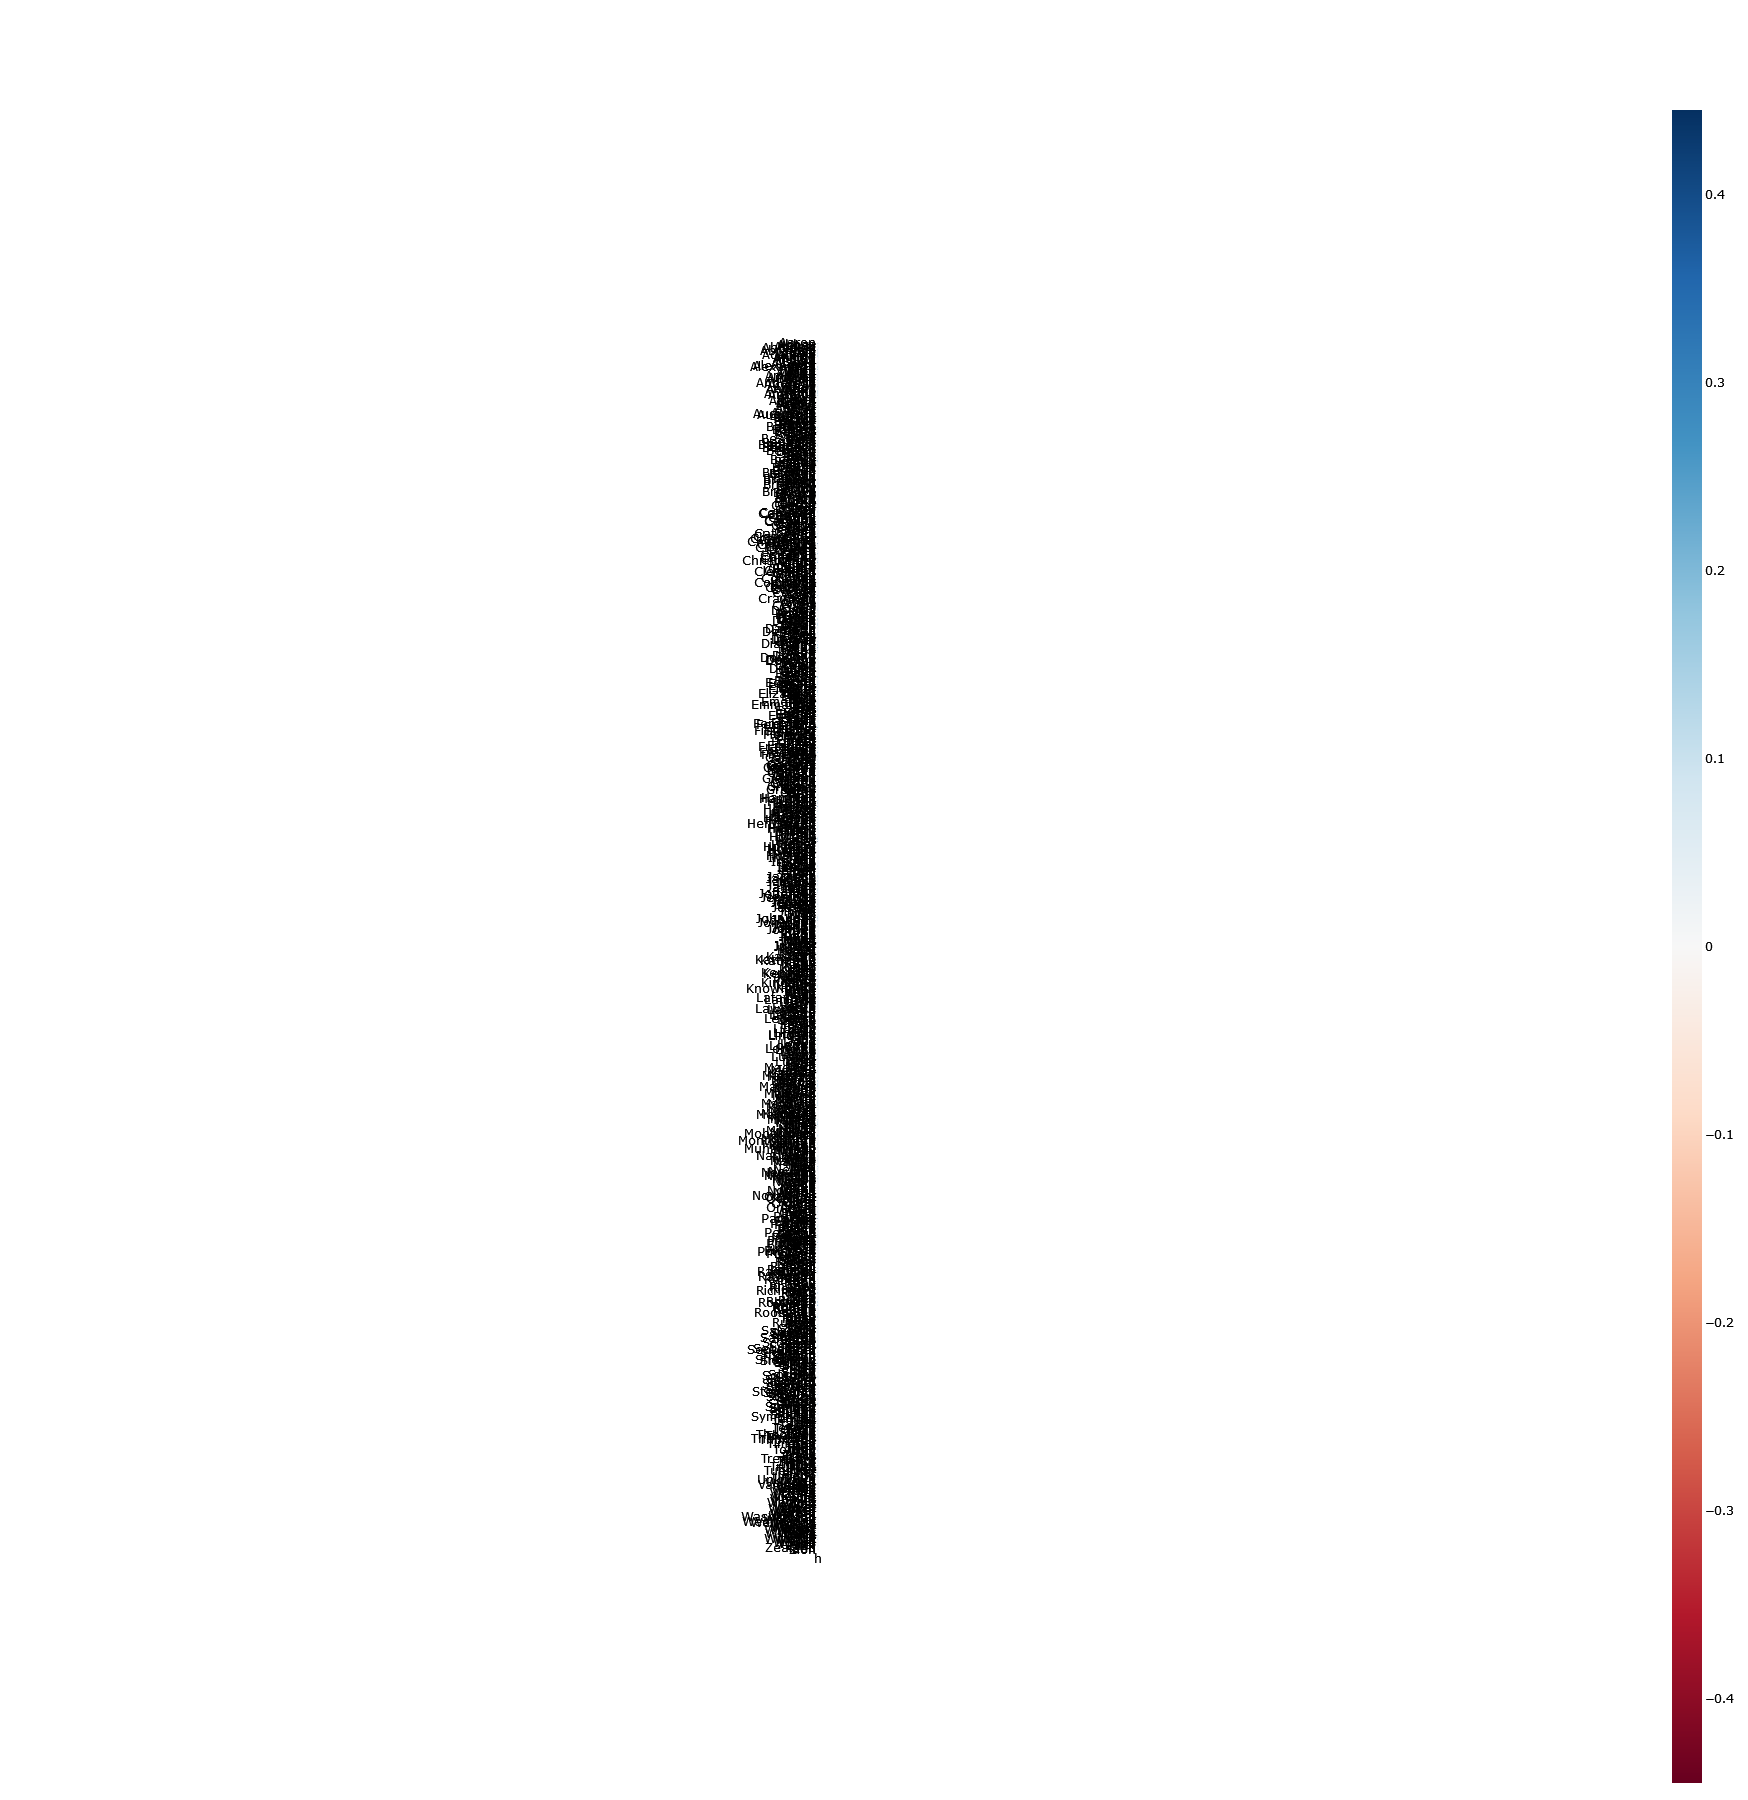

In [170]:

acts = activations.reshape(-1, 1, L)

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800*3,
        'height': 600*3,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

names_labels = acdc.data.ioi.good_names[:]

imshow(acts[:,:,-1], x=['h'], y=names_labels, font_size=12)




# y is first name, x is second

In [7]:

def detect_parity(l):
    num_swap = 0
    for k in range(len(l)-1):
        if l[k] != l[k+1]:
            num_swap += 1
    return num_swap

def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0
print(model.to_str_tokens(name_test_data[0]))
acts = activations.reshape(-1, 1, L)
outs = []
diffs = []
import math
for i in range(acts.size()[0]):
    out = []
    for j in range(1,300*2,2):
        out.append(acts[i,0,-j].item())
    diff = []
    for j in range(len(out)-1):
        diff.append(sign(out[j]-out[j+1]))
    diff.append(detect_parity(diff))
    diff.append(i)
    diffs.append(diff)
    #out.append(i)
    #outs.append(tuple(out))
#outs = sorted(outs)
diffs = sorted(diffs, key=lambda x: x[-2])
for diff in diffs:
    print(acdc.data.ioi.good_names[diff[-1]], diff[::-1]) # out[::-1])

['<|endoftext|>', 'L', 'ately', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' Aaron', ',', ' A

In [179]:
acts = activations.reshape(-1, 1, L)

inds = torch.argsort(acts[:,0,4])
for i in inds:
    print(acdc.data.ioi.good_names[i], acts[i,0,4].item())

Bruce 0.0
Spring 0.0
Brennan 0.0
Dylan 0.0
Duke 0.0
Male 0.0
Drake 0.0
Brock 0.0
Brooklyn 0.0
Brooks 0.0
Brown 0.0
Brain 0.0
Douglas 0.0
Marvel 0.0
Sierra 0.0
Donovan 0.0
Donald 0.0
Mercedes 0.0
Seven 0.0
Diamond 0.0
Mitchell 0.0
Sunni 0.0
Benedict 0.0
Leigh 0.0
Liam 0.0
Tesla 0.0
Lincoln 0.0
Lindsay 0.0
Tea 0.0
Lindsey 0.0
Elder 0.0
Denver 0.0
Summer 0.0
Bishop 0.0
Major 0.0
Malaysia 0.0
Booker 0.0
Stephen 0.0
Boston 0.0
Early 0.0
Star 0.0
Christie 0.0
Crew 0.0
October 0.0
Orlando 0.0
Cornell 0.0
Corbyn 0.0
Page 0.0
China 0.0
Paris 0.0
Raleigh 0.0
Cross 0.0
Parks 0.0
Columbus 0.0
Coleman 0.0
Pearson 0.0
Clinton 0.0
Promise 0.0
Princeton 0.0
Princess 0.0
Cleveland 0.0
My 0.0
Delta 0.0
Season 0.0
Canon 0.0
Dell 0.0
Dean 0.0
Dayton 0.0
Montgomery 0.0
Ruby 0.0
Royal 0.0
Luther 0.0
Roman 0.0
Rogers 0.0
Nevada 0.0
Nigeria 0.0
Dakota 0.0
Chancellor 0.0
Norman 0.0
Norris 0.0
Norton 0.0
Judge 0.0
Watson 0.0
Jeffrey 0.0
Golden 0.0
Jet 0.0
Gibson 0.0
Walton 0.0
Walker 0.0
Georgia 0.0
Johnson 0.0

# Manual Test Feature

In [122]:

indices = torch.round(feature_i_top_k_indices[2380]).long()
print(tokenized[indices[0].item()]['input_ids'])
feature_i_top_k_values[2380]

tensor([ 4930, 15877,   275,  ...,    94,   187,    61])


tensor([4.2673, 4.0469, 4.0382, 3.9979, 3.9902, 3.9018, 3.7470, 3.7401, 3.7275,
        3.6963, 3.6875, 3.6277, 3.5944, 3.5785, 3.5744, 3.5667, 3.5530, 3.5463,
        3.5434, 3.5374, 3.5213, 3.5202, 3.5123, 3.4987, 3.4917, 3.4869, 3.4850,
        3.4803, 3.4707, 3.4626, 3.4598, 3.4536, 3.4520, 3.4518, 3.4452, 3.4434,
        3.4391, 3.4332, 3.4228, 3.4105, 3.4003, 3.3875, 3.3851, 3.3741, 3.3713,
        3.3679, 3.3645, 3.3644, 3.3633, 3.3604, 3.3394, 3.3393, 3.3365, 3.3337,
        3.3295, 3.3251, 3.3204, 3.3172, 3.3167, 3.3156, 3.3148, 3.3126, 3.3100,
        3.3093, 3.3088, 3.2926, 3.2893, 3.2834, 3.2780, 3.2755, 3.2729, 3.2688,
        3.2681, 3.2591, 3.2584, 3.2529, 3.2470, 3.2467, 3.2449, 3.2411, 3.2411,
        3.2383, 3.2372, 3.2365, 3.2319, 3.2305, 3.2245, 3.2240, 3.2236, 3.2180,
        3.2175, 3.2166, 3.2073, 3.2071, 3.2070, 3.2032, 3.2001, 3.1926, 3.1894,
        3.1889, 3.1888, 3.1882, 3.1877, 3.1868, 3.1867, 3.1842, 3.1840, 3.1807,
        3.1799, 3.1783, 3.1750, 3.1743, 

In [5]:
from dataclasses import dataclass, field
from functools import partial


from tqdm import tqdm

with open("features_all_tokens_layer_15_with_collected_data.pkl", "rb") as f:
    features = pickle.load(f)



def forward_check_featuresf(data, features):
    
    global features_by_layer
    
    #with open("layer_15_features_on_large_data.pkl", "rb") as f:
    #    features = pickle.load(f)
    features_by_layer = defaultdict(lambda: [])
    for feature in features:
        feature.records = []
        features_by_layer[feature.layer].append(feature)

    # only bother with SAE on the layers we are checking
    layers_to_apply_sae = sorted(list(features_by_layer.keys()))
    hooks = [(f'blocks.{layer}.hook_out_proj', partial(sae_hook, layer=layer)) for layer in layers_to_apply_sae]
    _ = model.run_with_hooks(input=data, fwd_hooks=hooks, fast_ssm=True, fast_conv=True)
        
import traceback
def clicked(arg):
    with outputTesting:
        clear_output()
        try:
            if eval_data.value.strip() == "":
                text = text_itemw.value
                tokenized_input = torch.tensor([model.tokenizer.bos_token_id] + model.tokenizer.encode(text), device=model.cfg.device).reshape(1,-1)
            else:
                tokenized_input = eval(eval_data.value).reshape(1, -1)
                print("eval to", tokenized_input)
            feature_i = int(feature_index.value)
            L = tokenized_input.size()[1]
            for feature in features:
                if feature.feature_i == feature_i and feature.layer == 15:
                    feat = feature
            features_with_i = []
            for i in range(1, L):
                features_with_i.append(SAEFeature(layer=feat.layer, pos=i, feature_i=feature_i, attr=feat.attr))
            forward_check_features(tokenized_input, features=features_with_i)
            activations = torch.zeros(L)
            for feature in features_with_i:
                activations[feature.pos] = feature.records[0]
            toks = model.to_str_tokens(tokenized_input[0])
            print(toks)
            token_pos = torch.argmax(activations).item()
            
            if activations[token_pos] == 0.0:
                token_pos = L
            out_toks = []
            print(activations)
            for j,tok in enumerate(toks):
                if len(tok.strip()) == 0:
                    tok = repr(tok)
                tok = tok.replace("\n", "\\n")
                colored = f"<span id='ayy'><font color='white'>{tok}</font></span>"
                if j < 1: continue
                if j == token_pos:
                    colored = f"<span id='ayy'><font color='red'>{tok}</font></span>"
                elif activations[j].item() > 0.01:
                    colored = f"<span id='ayy'><font color='pink'>{tok}</font></span>"
                if activations[j].item() > 0.01:
                    out_toks.append(f"{colored}{activations[j].item():.3f}")
                else:
                    out_toks.append(colored)
            simpler = model.tokenizer.decode(tokenized_input[0,1:token_pos+1])
            print(simpler)
            if token_pos == L:
                print("all zero")
            else:
                display(HTML(toks[token_pos] + "\t<br/><br/>\t" + "<span id='ayy'>" + simpler + "</span>\t<br/><br/>\t" + "".join(out_toks))) 
        except:
            print(traceback.format_exc())

                
text_itemw = widgets.Text(
    value='',
    placeholder='Test String',
    description='Test String',
    disabled=False,
    continuous_update=False,
)

feature_index = widgets.Text(
    value='',
    placeholder='Feature Index',
    description='Feature Index',
    disabled=False,
    continuous_update=False,
)
eval_data = widgets.Text(
    value='',
    placeholder='Eval Tokens',
    description='Eval Tokens',
    disabled=False,
    continuous_update=False,
)

button_download = widgets.Button(description = 'Test')   
button_download.on_click(clicked)

outputTesting = widgets.Output()

display(text_itemw)
display(feature_index)
display(eval_data)
display(button_download)
display(outputTesting)


Text(value='', continuous_update=False, description='Test String', placeholder='Test String')

Text(value='', continuous_update=False, description='Feature Index', placeholder='Feature Index')

Text(value='', continuous_update=False, description='Eval Tokens', placeholder='Eval Tokens')

Button(description='Test', style=ButtonStyle())

Output()

In [120]:
top_k_data[feature_to_storage_index[2380], 1]

tensor([0.0000, 0.0000, 0.0000, 0.0587, 0.0000, 2.2101, 0.0623, 0.0815, 0.1905,
        0.2061, 0.0000, 0.0000, 2.9549, 0.0000, 0.1316, 0.0923, 0.0353, 0.0729,
        0.1159, 0.1034, 1.4236, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0722,
        0.0818, 0.0000, 0.0846, 0.1015, 0.1813, 0.0664, 0.0000, 0.1172, 0.1185,
        0.0000, 0.0000, 0.0831, 0.0509, 0.2250, 0.0000, 0.0000, 0.0000, 0.0944,
        0.1050, 0.0000, 0.0000, 0.1076, 0.0000, 0.0000, 0.0755, 0.0982, 0.2454,
        0.0363, 0.2620, 0.0663, 0.0319, 0.0000, 0.1723, 0.0000, 0.1357, 0.1387,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6378, 0.0380, 0.0000, 0.0000, 0.0615,
        0.0000, 0.0814, 0.0000, 0.0000, 0.0000, 0.1411, 0.1213, 0.0705, 0.1159,
        0.0000, 0.0480, 0.0000, 0.1029, 0.0000, 0.0610, 0.0000, 0.0934, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1007, 0.1180, 0.0493, 0.0546,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0480, 0.0858,
        0.0364, 0.0000, 0.1876, 0.0535, 

# Display TopK Activations from Dataset subset

In [4]:

with open("layer_15_top_act_data.pkl", "rb") as f:
    feature_i_top_k_indices, feature_i_top_k_values = pickle.load(f)

with open("all_15_data_topk.pkl", "rb") as f:
    top_k_data = pickle.load(f)

with open("all_15_top_dataset_tokens.pkl", "rb") as f:
    token_data = pickle.load(f)


with open("layer_15_features.pkl", "rb") as f:
    feature_labels = pickle.load(f)
with open("layer_15_features_take_two.pkl", "rb") as f:
    feature_labelsb = pickle.load(f)

K = 400

all_feature_i = sorted(list(feature_i_top_k_indices.keys()))
feature_to_storage_index = dict([(feat_i,index) for (index,feat_i) in enumerate(all_feature_i)])



from IPython.display import display, clear_output
from ipywidgets import widgets
from IPython.display import display, HTML
global cur_feature_ind
cur_feature_ind = None
def display_unlabeled_feature():
    global cur_feature_ind
    global feature_labels
    available_features = features_sorted_by_feat_i.keys() - feature_labelsb.keys()
    maybe = []
    for f in available_features:
        #if len(feature_labels[f].strip()) != 1: continue
        if '?' not in feature_labels[f]:
           continue
        maybe.append((features_sorted_by_feat_i[f][0].attr, f))
        continue

    maybe.sort(key=lambda x: x[0])
    for attr, f in maybe:
        print(attr)
        print(f"feature {f}")
        cur_feature_ind = f
        text_item.value = feature_labels[f]
        #if any([position_map[feat.pos][0] != 'n' for feat in feats]):
            #print(f"warning, feature {feat_i} has non name poses, all pos are {[position_map[f.pos] for f in feats]})")
        #    continue
        display_feat(cur_feature_ind)
        return
    num_left = 0
    for f in feature_labels.keys():
        if "?" in feature_labels[f]:
            num_left += 1
    print(f"num left {num_left}")
    for f in feature_labels.keys():
        if "?" in feature_labels[f]:
            cur_feature_ind = f
            text_item.value = feature_labels[f]
            display_feats(features_sorted_by_feat_i[f])
            return

display(HTML("""<link href='https://fonts.googleapis.com/css?family=Noto Sans' rel='stylesheet'>
<style>
/* Base Noto Sans and Serif for Latin, Greek, and Cyrillic */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans:wght@400;700&family=Noto+Serif:wght@400;700&display=swap');

/* East Asian scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+JP:wght@400;700&family=Noto+Sans+KR:wght@400;700&family=Noto+Sans+SC:wght@400;700&family=Noto+Sans+TC:wght@400;700&display=swap');

/* South Asian scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Devanagari:wght@400;700&family=Noto+Sans+Bengali:wght@400;700&family=Noto+Sans+Tamil:wght@400;700&display=swap');

/* Middle Eastern scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Arabic:wght@400;700&family=Noto+Sans+Hebrew:wght@400;700&display=swap');

/* Other scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Thai:wght@400;700&family=Noto+Sans+Ethiopic:wght@400;700&display=swap');

/* Specialty fonts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Mono:wght@400;700&family=Noto+Color+Emoji&display=swap');

#ayy {
  font-family: 'Noto Sans', 'Noto Sans JP', 'Noto Sans KR', 'Noto Sans SC', 'Noto Sans TC', 
               'Noto Sans Devanagari', 'Noto Sans Bengali', 'Noto Sans Tamil', 
               'Noto Sans Arabic', 'Noto Sans Hebrew', 'Noto Sans Thai', 'Noto Sans Ethiopic',
               sans-serif;
}

/* Language-specific rules */
:lang(ja) { font-family: 'Noto Sans JP', sans-serif; }
:lang(ko) { font-family: 'Noto Sans KR', sans-serif; }
:lang(zh-CN) { font-family: 'Noto Sans SC', sans-serif; }
:lang(zh-TW) { font-family: 'Noto Sans TC', sans-serif; }
:lang(hi) { font-family: 'Noto Sans Devanagari', sans-serif; }
:lang(bn) { font-family: 'Noto Sans Bengali', sans-serif; }
:lang(ta) { font-family: 'Noto Sans Tamil', sans-serif; }
:lang(ar) { font-family: 'Noto Sans Arabic', sans-serif; }
:lang(he) { font-family: 'Noto Sans Hebrew', sans-serif; }
:lang(th) { font-family: 'Noto Sans Thai', sans-serif; }
:lang(am), :lang(ti) { font-family: 'Noto Sans Ethiopic', sans-serif; }

/* Emoji support */
.emoji {
  font-family: 'Noto Color Emoji', sans-serif;
}
</style>"""))
def display_feat(feature_i):
    covered_already = set()
    simpler_words = []
    for k in range(K):
        storage_index = feature_to_storage_index[feature_i]
        activations = top_k_data[storage_index, k]
        tokens = token_data[storage_index, k]
        token_pos = torch.argmax(activations).item()
        toks = model.to_str_tokens(tokens)
        relevant_str = "".join(toks[:token_pos+1])
        if relevant_str in covered_already:
            continue
        covered_already.add(relevant_str)
        out_toks = []
        colors = [''] + ['red', 'orange', 'yellow', 'green']*256
        for j,tok in enumerate(toks):
            if len(tok.strip()) == 0:
                tok = repr(tok)
            tok = tok.replace("\n", "\\n")
            colored = f"<span id='ayy'><font color='white'>{tok}</font></span>"
            if j < 1: continue
            if j == token_pos:
                colored = f"<span id='ayy'><font color='red'>{tok}</font></span>"
            elif activations[j].item() > 0.01:
                colored = f"<span id='ayy'><font color='pink'>{tok}</font></span>"
            if activations[j].item() > 0.01:
                out_toks.append(f"{colored}{activations[j].item():.3f}")
            else:
                out_toks.append(colored)
        simpler = model.tokenizer.decode(tokens[1:token_pos+1])
        simpler_words.append(simpler.strip())

        display(HTML(toks[token_pos] + "\t||\t" + "<span id='ayy'>" + simpler + "</span>\t||\t" + "".join(out_toks)))
        if len(simpler_words) == 20:
            out_s = "<span id='ayy'>What do "
            for s in simpler_words:
                out_s += f'"{s.strip()}", '
            out_s += "have in common? Take a deep breath and think step by step."
            display(HTML(out_s + "</span>"))
    '''
    feat_vecs = [get_name_vector(feat, 'mean') for feat in feats]
    avg_vec = torch.stack(feat_vecs).mean(dim=0)
    min_vec = torch.stack([get_name_vector(feat, 'min') for feat in feats]).min(dim=0).values
    max_vec = torch.stack([get_name_vector(feat, 'max') for feat in feats]).max(dim=0).values
    sorted_names = torch.argsort(-avg_vec)
    #print(avg_vec, min_vec, max_vec, sorted_names)
    for name_i in sorted_names[:100]:
        #print(name_i)
        print(f" name {names[name_i]} with avg {avg_vec[name_i]} min {min_vec[name_i]} max {max_vec[name_i]}")
    '''
    '''
    for feat in feats:
        if position_map[feat.pos][0] == 'n':
            print(position_map[feat.pos], detect_single_letter(feat))
            pretty_print_list_first_letter_info(list_first_letter_info(feat))
            print(improved_first_letter(feat))
    
    diffs = torch.zeros(len(feats), len(feats))
    for i,featv1 in enumerate(feat_vecs):
        for j,featv2 in enumerate(feat_vecs):
            diffs[i,j] = torch.mean(torch.abs(featv1-featv2))
    labels = [position_map[feat.pos] for feat in feats]
    imshow(diffs, x=labels, y=labels, font_size=9)
    '''
def save_labels():
    with open("layer_15_features_take_two.pkl", "wb") as f:
        global feature_labelsb
        pickle.dump(feature_labelsb, f)
        print(f"done saving {len(feature_labelsb)}")
import traceback
out = widgets.Output()
global cur_feature_ind
global feature_labels
def submitted(change):
    global cur_feature_ind
    global feature_labels
    if len(text_item.value.strip()) > 0 and (text_item.value != feature_labels[cur_feature_ind]):
        with out:
            try:
                times = 0
                clear_output()
                feature_labelsb[cur_feature_ind] = text_item.value
                save_labels()
                display_unlabeled_feature()
            except:
                print(traceback.format_exc())
                



text_item = widgets.Text(
    value='ffff',
    placeholder='Type something',
    description='String:',
    disabled=False,
    continuous_update=False,
)

display(text_item)
display(out)
text_item.observe(submitted, names='value')

with out:
    display_unlabeled_feature()
    






Text(value='ffff', continuous_update=False, description='String:', placeholder='Type something')

Output()

In [21]:
import torch
with open("textlayer15.pkl", "rb") as f:
    dat = torch.load(f)

ModuleNotFoundError: No module named 'cPickle'

307.0


In [ ]:
import torch
with open("textlayer15.pkl", "wb") as f:
    torch.save(features, f)

In [2]:
global feature_labels
import pickle
with open("layer_15_features.pkl", "rb") as f:
    feature_labels = pickle.load(f)



In [3]:
global feature_labels
import pickle
with open("layer_15_features_take_two.pkl", "rb") as f:
    feature_labelsb = pickle.load(f)


In [5]:
print(feature_labelsb)

{6146: 'M (also fires on final token of M words)', 4104: 'May, five, fifth ', 10252: 'R ', 12348: 'Famous Actors, actor portrayal, embodied, playing', 24649: "? used to be 1800's and 1900's", 22605: 'Repeated Token', 12365: '? ', 2129: 'Michigan Locations (previously MMA Wrestling and Sports)', 12371: 'Middle East Diplomacy (also haemostatic/thrombosis/punk rock/hematopoiesis)', 6227: 'Russian Names, 3 digit numbers, renal excretions, and escaped quotes', 2165: '? Muilti token phrases maybe?', 4214: 'quantum terminology ', 6266: 'me/you/your (previously interactions with webpage)', 20604: 'Kidney Function', 16512: '?, accountants, marriage and health (microbiome, antioxidants) related terms', 6272: 'Human Suffering (Cancer, Auschwitz, Guantanamo Bay, Divorce, Chernobyl) previously renal cancer terms/sports teams', 30887: 'denominator of/simplify sqrt(, previouslywine tasting', 14506: 'words put together with no space (prevoiusly all caps licensing/warranty terms)', 20651: 'Russia relat

In [8]:

from IPython.display import display, clear_output
from ipywidgets import widgets
from IPython.display import display, HTML
global cur_feature_ind
cur_feature_ind = None
def display_unlabeled_feature():
    global cur_feature_ind
    global feature_labels
    available_features = features_sorted_by_feat_i.keys() - feature_labelsb.keys()
    for f in available_features:
        if not '?' in feature_labels[f]:
            continue
        print(f"feature {f}")
        cur_feature_ind = f
        feats = features_sorted_by_feat_i[f]
        text_item.value = feature_labels[f]
        #if any([position_map[feat.pos][0] != 'n' for feat in feats]):
            #print(f"warning, feature {feat_i} has non name poses, all pos are {[position_map[f.pos] for f in feats]})")
        #    continue
        display_feats(feats)
        return
    num_left = 0
    for f in feature_labels.keys():
        if "?" in feature_labels[f]:
            num_left += 1
    print(f"num left {num_left}")
    for f in feature_labels.keys():
        if "?" in feature_labels[f]:
            cur_feature_ind = f
            text_item.value = feature_labels[f]
            display_feats(features_sorted_by_feat_i[f])
            return

print(data.size())
display(HTML("""<link href='https://fonts.googleapis.com/css?family=Noto Sans' rel='stylesheet'>
<style>
/* Base Noto Sans and Serif for Latin, Greek, and Cyrillic */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans:wght@400;700&family=Noto+Serif:wght@400;700&display=swap');

/* East Asian scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+JP:wght@400;700&family=Noto+Sans+KR:wght@400;700&family=Noto+Sans+SC:wght@400;700&family=Noto+Sans+TC:wght@400;700&display=swap');

/* South Asian scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Devanagari:wght@400;700&family=Noto+Sans+Bengali:wght@400;700&family=Noto+Sans+Tamil:wght@400;700&display=swap');

/* Middle Eastern scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Arabic:wght@400;700&family=Noto+Sans+Hebrew:wght@400;700&display=swap');

/* Other scripts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Thai:wght@400;700&family=Noto+Sans+Ethiopic:wght@400;700&display=swap');

/* Specialty fonts */
@import url('https://fonts.googleapis.com/css2?family=Noto+Sans+Mono:wght@400;700&family=Noto+Color+Emoji&display=swap');

#ayy {
  font-family: 'Noto Sans', 'Noto Sans JP', 'Noto Sans KR', 'Noto Sans SC', 'Noto Sans TC', 
               'Noto Sans Devanagari', 'Noto Sans Bengali', 'Noto Sans Tamil', 
               'Noto Sans Arabic', 'Noto Sans Hebrew', 'Noto Sans Thai', 'Noto Sans Ethiopic',
               sans-serif;
}

/* Language-specific rules */
:lang(ja) { font-family: 'Noto Sans JP', sans-serif; }
:lang(ko) { font-family: 'Noto Sans KR', sans-serif; }
:lang(zh-CN) { font-family: 'Noto Sans SC', sans-serif; }
:lang(zh-TW) { font-family: 'Noto Sans TC', sans-serif; }
:lang(hi) { font-family: 'Noto Sans Devanagari', sans-serif; }
:lang(bn) { font-family: 'Noto Sans Bengali', sans-serif; }
:lang(ta) { font-family: 'Noto Sans Tamil', sans-serif; }
:lang(ar) { font-family: 'Noto Sans Arabic', sans-serif; }
:lang(he) { font-family: 'Noto Sans Hebrew', sans-serif; }
:lang(th) { font-family: 'Noto Sans Thai', sans-serif; }
:lang(am), :lang(ti) { font-family: 'Noto Sans Ethiopic', sans-serif; }

/* Emoji support */
.emoji {
  font-family: 'Noto Color Emoji', sans-serif;
}
</style>"""))
def display_feats(feats):
    all_records = []
    feat_len = len(feats[0].records)
    for feat in feats:
        print(feat.pos)
        all_records += feat.records
    records = torch.tensor(all_records)
    dats = [torch.tensor([1]).repeat(feat_len),torch.tensor([2]).repeat(feat_len),torch.tensor([3]).repeat(feat_len),torch.tensor([4]).repeat(feat_len)]
    which_pos = torch.cat(dats)
    print(records.size())
    top_act_inds = torch.argsort(-records)
    covered_already = set()
    simpler_words = []
    for i in range(500):
        ind = top_act_inds[i]
        token_pos = which_pos[ind]
        data_pos = ind % feat_len
        act = records[ind]
        acts = [0]
        for j in range(1,5):
            acts.append([feat.records[data_pos] for feat in feats if feat.pos == j][0])
        toks = model.to_str_tokens(data[data_pos])
        relevant_str = "".join(toks[:token_pos+1])
        if relevant_str in covered_already:
            continue
        covered_already.add(relevant_str)
        out_toks = []
        colors = ['', 'red', 'orange', 'yellow', 'green']
        for j,tok in enumerate(toks):
            if len(tok.strip()) == 0:
                tok = repr(tok)
            tok = tok.replace("\n", "\\n")
            colored = f"<span id='ayy'><font color='{colors[j]}'>{tok}</font></span>"
            if j < 1: continue
            if j == token_pos:
                colored = f"<span id='ayy'><font color='pink'>{tok}</font</span>"
            if acts[j] > 0.01:
                out_toks.append(f"{colored}{acts[j]:.3f}")
            else:
                out_toks.append(colored)
        simpler = model.tokenizer.decode(data[data_pos][1:token_pos+1])
        simpler_words.append(simpler.strip())

        display(HTML(toks[token_pos] + "\t||\t" + "<span id='ayy'>" + simpler + "</span>\t||\t" + "".join(out_toks)))
        if len(simpler_words) == 20:
            out_s = "<span id='ayy'>What do "
            for s in simpler_words:
                out_s += f'"{s.strip()}", '
            out_s += "have in common? Take a deep breath and think step by step."
            display(HTML(out_s + "</span>"))
    '''
    feat_vecs = [get_name_vector(feat, 'mean') for feat in feats]
    avg_vec = torch.stack(feat_vecs).mean(dim=0)
    min_vec = torch.stack([get_name_vector(feat, 'min') for feat in feats]).min(dim=0).values
    max_vec = torch.stack([get_name_vector(feat, 'max') for feat in feats]).max(dim=0).values
    sorted_names = torch.argsort(-avg_vec)
    #print(avg_vec, min_vec, max_vec, sorted_names)
    for name_i in sorted_names[:100]:
        #print(name_i)
        print(f" name {names[name_i]} with avg {avg_vec[name_i]} min {min_vec[name_i]} max {max_vec[name_i]}")
    '''
    '''
    for feat in feats:
        if position_map[feat.pos][0] == 'n':
            print(position_map[feat.pos], detect_single_letter(feat))
            pretty_print_list_first_letter_info(list_first_letter_info(feat))
            print(improved_first_letter(feat))
    
    diffs = torch.zeros(len(feats), len(feats))
    for i,featv1 in enumerate(feat_vecs):
        for j,featv2 in enumerate(feat_vecs):
            diffs[i,j] = torch.mean(torch.abs(featv1-featv2))
    labels = [position_map[feat.pos] for feat in feats]
    imshow(diffs, x=labels, y=labels, font_size=9)
    '''
def save_labels():
    with open("layer_15_features_take_two.pkl", "wb") as f:
        global feature_labelsb
        pickle.dump(feature_labelsb, f)
        print(f"done saving {len(feature_labelsb)}")
import traceback
out = widgets.Output()
global cur_feature_ind
global feature_labels
def submitted(change):
    global cur_feature_ind
    global feature_labels
    if len(text_item.value.strip()) > 0 and (text_item.value != feature_labels[cur_feature_ind]):
        with out:
            try:
                times = 0
                clear_output()
                feature_labelsb[cur_feature_ind] = text_item.value
                save_labels()
                display_unlabeled_feature()
            except:
                print(traceback.format_exc())
                



text_item = widgets.Text(
    value='ffff',
    placeholder='Type something',
    description='String:',
    disabled=False,
    continuous_update=False,
)

display(text_item)
display(out)
text_item.observe(submitted, names='value')

with out:
    display_unlabeled_feature()
    

torch.Size([389372, 5])


Text(value='ffff', continuous_update=False, description='String:', placeholder='Type something')

Output()

In [9]:
from IPython.display import display, FileLink
import os
display(FileLink("layer_15_features.pkl"))

/home/dev/sae-k-sparse-mamba/layer_15_features.pkl

In [139]:






























combined = {}
for f in feature_labels.keys():
    if f in feature_labelsb:
        combined[f] = feature_labels[f] + " MOREDATA: " + feature_labelsb[f].replace("?", " ").strip()
    else:
        combined[f] = feature_labels[f]
    
    if f in feature_labelsb and feature_labelsb[f].strip()  == feature_labels[f].strip():
        combined[f] = feature_labels[f]
    
    if feature_labels[f].replace("?", "").strip() == "" and f in feature_labelsb:
        combined[f] = feature_labelsb[f]
    combined[f] = combined[f].replace("?", " ").replace("(", " ").replace(")", " ").strip()
    if combined[f].strip() == "" or combined[f].strip() == '||':
        del combined[f]
labs = sorted(list(combined.items()), key=lambda x: x[1].lower().strip())
for f,l in labs:
    #if not '?' in l:
    if l.strip() != "":
        print(f, l)
        print(f"  attr {features_sorted_by_feat_i[f][0].attr}")
for f in feature_labels.keys():
    if len([(f2,l) for (f2,l) in labs if f2 == f]) == 0:
        print(f"unknown {f} with attr {features_sorted_by_feat_i[f][0].attr}")
        combined[f] = feature_labels[f]
labs = sorted(list(combined.items()), key=lambda x: features_sorted_by_feat_i[x[0]][0].attr)
for f,l in labs:
    #if not '?' in l:
    if l.strip() != "":
        print(f, l)
        print(f"  attr {features_sorted_by_feat_i[f][0].attr}")



print(f"total num features identified {len(labs)}")

24649 1800's and 1900's MOREDATA: used to be 1800's and 1900's
  attr -0.013689302893567401
15582 1800-1999
  attr -0.009123188330249832
30568 1980's-1990s pop culture
  attr -0.012585221676090441
6227 3 digit numbers, renal excretions, and escaped quotes MOREDATA: Russian Names, 3 digit numbers, renal excretions, and escaped quotes
  attr -0.008696446947169534
8103 5/May/Five/Fifth
  attr -0.01274918073158915
32395 [ with some other symbols  [", **[, etc.
  attr -0.006224751563763675
31021 A
  attr -0.09784678883806919
29892 A
  attr -0.0719999106204341
14819 about names
  attr -0.009356041136925342
1312 account/login terminology and oxidation/breathing
  attr -0.017313731845206348
12348 actor portrayal, embodied, playing MOREDATA: Famous Actors, actor portrayal, embodied, playing
  attr -0.010314146090422582
19724 aggressive/vigorously
  attr -0.01069634652901641
21271 Airline Brands and Punk Rock bands
  attr -0.0069216288079587684
15562 all caps hurricaine/military codename stuff
 

In [19]:
feature_labelsb

{6146: 'M (also fires on final token of M words)',
 4104: 'May, five, fifth ',
 10252: 'R ',
 12348: 'Famous Actors, actor portrayal, embodied, playing',
 24649: "? used to be 1800's and 1900's",
 22605: 'Repeated Token'}

In [28]:
" Purushottam".strip()

'Purushottam'